## Hierarchical cluster analysis

In [1]:
library(ggplot2)
library(dplyr)
library(stats)
library(sf)
library(geosphere)
library(patchwork)
library(cluster)
library(maps)


Caricamento pacchetto: ‘dplyr’


I seguenti oggetti sono mascherati da ‘package:stats’:

    filter, lag


I seguenti oggetti sono mascherati da ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE


Caricamento pacchetto: ‘maps’


Il seguente oggetto è mascherato da ‘package:cluster’:

    votes.repub




In [2]:
#load the data
df1 = read.table("./data/earthquakes_years_2000_2025.csv", header=TRUE, sep=',')
df2 = read.table("./data/earthquakes_years_1925_2000.csv", header=TRUE, sep=',')
cat("The 1st database has ", nrow(df1), " rows", "\n")
cat("The 2nd database has ", nrow(df2), " rows", "\n")
df = rbind(df1, df2)
cat("The final database has ", nrow(df), " rows", "\n")


The 1st database has  13988  rows 
The 2nd database has  14850  rows 
The final database has  28838  rows 


In [3]:
df$time <- as.POSIXct(df$time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")
head(df,10)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,⋯,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
1,2025-06-24 03:04:54,41.4136,19.5656,10.000,4.2,mb,41,56,0.233,0.98,⋯,2025-06-24T08:13:22.962Z,"7 km N of Shijak, Albania",earthquake,4.47,1.932,0.110,23,reviewed,us,us
2,2025-06-21 14:56:54,38.0214,20.2244,53.184,4.2,mb,20,124,1.591,0.98,⋯,2025-06-21T15:51:45.040Z,"27 km SW of Lixoúri, Greece",earthquake,2.82,12.614,0.200,9,reviewed,us,us
3,2025-06-21 13:25:52,37.9115,20.1867,10.000,4.5,mb,41,107,1.563,1.14,⋯,2025-06-22T11:05:17.735Z,"38 km SW of Lixoúri, Greece",earthquake,6.06,1.895,0.079,47,reviewed,us,us
4,2025-06-01 16:44:09,43.1747,17.9562,10.000,4.0,mb,49,31,1.215,0.68,⋯,2025-06-22T16:37:44.040Z,"8 km ENE of Crnići, Bosnia and Herzegovina",earthquake,5.05,1.931,0.150,12,reviewed,us,us
5,2025-05-22 22:52:00,42.5041,18.3603,10.000,4.0,mb,33,42,0.670,0.82,⋯,2025-06-08T22:23:48.661Z,"12 km WNW of Igalo, Montenegro",earthquake,2.14,1.927,0.123,18,reviewed,us,us
6,2025-05-20 22:37:03,45.9604,11.1350,11.615,2.7,ml,25,79,0.369,0.60,⋯,2025-05-21T13:40:42.272Z,"2 km NE of Besenello, Italy",earthquake,2.28,5.934,0.057,40,reviewed,us,us
7,2025-05-13 10:07:45,40.8277,14.0646,10.000,4.0,mwr,65,105,0.432,0.45,⋯,2025-06-05T13:58:19.046Z,"3 km SW of Pozzuoli, Italy",earthquake,5.26,1.909,0.093,11,reviewed,us,us
8,2025-05-11 11:46:53,42.9684,18.6709,10.000,4.4,mb,47,37,0.692,0.79,⋯,2025-06-13T05:29:08.040Z,"22 km ENE of Bileća, Bosnia and Herzegovina",earthquake,4.11,1.932,0.130,17,reviewed,us,us
9,2025-05-10 04:51:34,38.0915,20.3410,42.571,4.1,mb,36,119,1.553,0.99,⋯,2025-05-26T22:31:13.040Z,"14 km SW of Lixoúri, Greece",earthquake,6.39,10.659,0.140,14,reviewed,us,us


In [5]:
df_cleaned <- df[, c('time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'id','place', 'locationSource', 'status') ]
# check for NA values in selected columns:
for (col in 1:length(df_cleaned) ) {
    cat("Number of NA values in column ", col, ": ", sum(is.na(df_cleaned[1])), "\n")
}

Number of NA values in column  1 :  0 
Number of NA values in column  2 :  0 
Number of NA values in column  3 :  0 
Number of NA values in column  4 :  0 
Number of NA values in column  5 :  0 
Number of NA values in column  6 :  0 
Number of NA values in column  7 :  0 
Number of NA values in column  8 :  0 
Number of NA values in column  9 :  0 
Number of NA values in column  10 :  0 


In [18]:
ev_coordinates <- df_cleaned %>%
  filter(mag > 5) %>% filter(grepl("Italy$", place)) %>%
  select(longitude, latitude, depth)

dist_matrix <- distm(ev_coordinates, fun = distHaversine)  # distances between the events

In [19]:
dim(dist_matrix)
any(is.na(dist_matrix))
class(dist_matrix)
str(dist_matrix)
class(dist_matrix)

[1] 201 201

[1] FALSE

[1] "matrix" "array"

 num [1:201, 1:201] 0 228460 656318 144368 612804 ...


[1] "matrix" "array"

In [28]:
h_cluster <- hclust(as.dist(dist_matrix), method = "ward.D2") # we can use other methods instead ward.D2
# Tagliamo l'albero in k cluster (es. 4)
cluster <- cutree(h_cluster, k = 3)

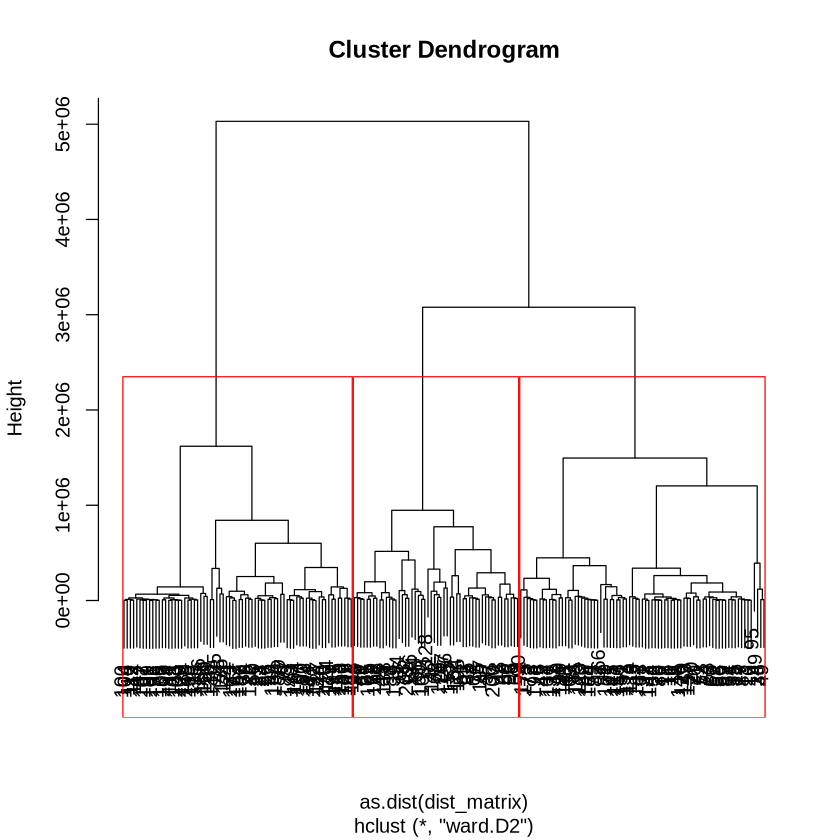

In [29]:
plot(h_cluster)
rect.hclust(h_cluster, k = 3, border = "red")  # Cut into 4 clusters

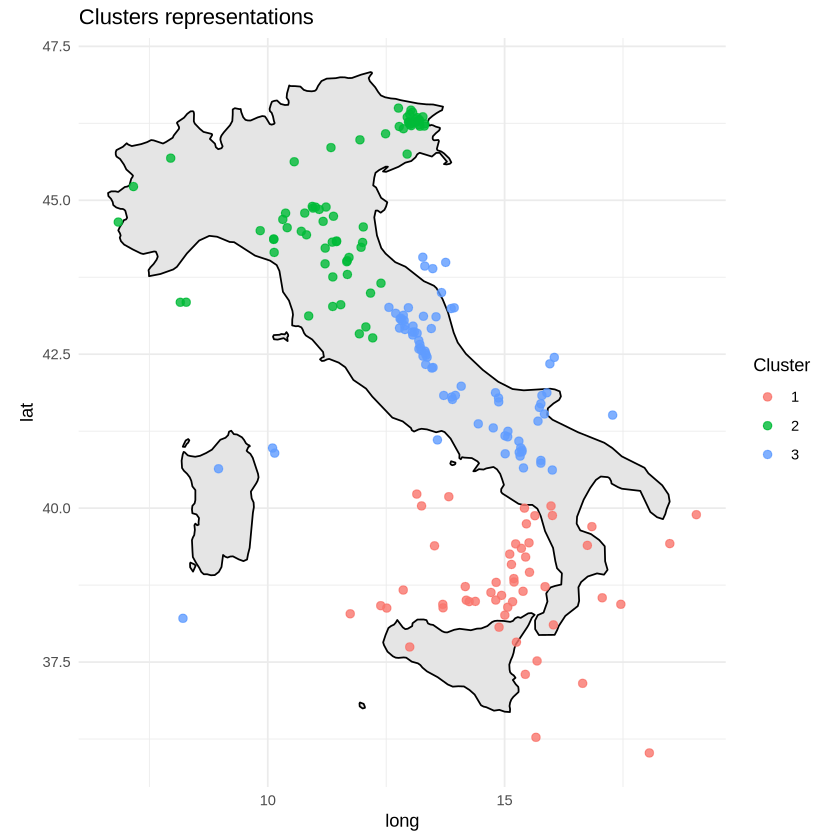

In [30]:
# Aggiungiamo i cluster al data frame
ev_coordinates$cluster <- factor(cluster)  # meglio come fattore per i colori

# Mappa base dell’Italia
italy_map <- map_data("world", region = "Italy")

# Plot
ggplot() +
  geom_polygon(data = italy_map, aes(x = long, y = lat, group = group),
               fill = "gray90", color = "black") +
  geom_point(data = ev_coordinates, aes(x = longitude, y = latitude, color = cluster),
             size = 2, alpha = 0.8) +
  coord_fixed(1.3) +
  theme_minimal() +
  labs(title = "Clusters representations", color = "Cluster" )

#aggiungere bordo placche tettoniche 